#### cuda 사용여부 확인

In [1]:
import torch

# 현재 GPU 사용 여부 확인
print("CUDA 사용 가능 여부:", torch.cuda.is_available())
print("현재 사용 중인 디바이스:", torch.device("cuda" if torch.cuda.is_available() else "cpu"))


CUDA 사용 가능 여부: False
현재 사용 중인 디바이스: cpu


#### TensorFlow 비활성화

In [ ]:
# import os
# os.environ["USE_TF"] = "0"  # TensorFlow 강제 비활성화
# os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
# os.environ["DISABLE_MLFLOW_INTEGRATION"] = "TRUE"


### 허깅 페이스 cli 설치 및 로그인

In [ ]:
# !pip install --upgrade huggingface_hub

In [2]:
from huggingface_hub import notebook_login

notebook_login()

## 라이브러리 설치

In [ ]:
# !pip install torch transformers peft datasets tqdm accelerate

## 허깅페이스에서 모델을 다운로드하고 로컬에 저장하기

- Qwen/Qwen2-7B-Instruct
    - https://github.com/QwenLM/Qwen
    - https://huggingface.co/Qwen/Qwen2-7B-Instruct/tree/main

In [ ]:
# !pip install blobfile sentencepiece

   ---------------------------------------- 0.0/991.5 kB ? eta -:--:--
   --------------------------------------- 991.5/991.5 kB 23.5 MB/s eta 0:00:00
   ---------------------------------------- 0.0/3.8 MB ? eta -:--:--
   ---------------------------------------- 3.8/3.8 MB 45.4 MB/s eta 0:00:00
   ---------------------------------------- 0.0/1.8 MB ? eta -:--:--
   ---------------------------------------- 1.8/1.8 MB 16.5 MB/s eta 0:00:00


In [ ]:
# !pip install --upgrade sentencepiece


### 다운로드 코드 한번만 실행....

In [3]:
import os
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer

# 다운로드 시간 제한을 환경 변수로 설정 (10분)
os.environ["HF_HUB_DOWNLOAD_TIMEOUT"] = "600"

# 모델명 지정 (Hugging Face에서 다운로드)
model_name = "Qwen/Qwen2-7B-Instruct"

# 모델 저장 경로
save_path = "../../data/models/Qwen2-7B-Instruct"

# 모델 다운로드 (재시도 기능 추가)
def load_model_with_retry(model_name, max_retries=3):
    for attempt in range(max_retries):
        try:
            print(f"모델 다운로드 시도 {attempt + 1}/{max_retries}...")

            # 모델 및 토크나이저 다운로드 (Qwen 모델은 trust_remote_code=True 필요)
            model = AutoModelForCausalLM.from_pretrained(model_name, trust_remote_code=True)

            tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)

            # 모델 & 토크나이저 로컬 저장
            model.save_pretrained(save_path)
            tokenizer.save_pretrained(save_path)

            print(f"모델이 '{save_path}' 경로에 성공적으로 저장되었습니다!")
            return model, tokenizer  # 성공 시 반환

        except Exception as e:
            print(f"오류 발생: {e}")
            if attempt < max_retries - 1:
                print("다시 시도 중...")
            else:
                print("모델 다운로드 실패. 인터넷 연결 확인 또는 수동 다운로드 필요.")
                raise e

# 모델 다운로드 및 저장 실행
model, tokenizer = load_model_with_retry(model_name)


모델 다운로드 시도 1/3...


config.json:   0%|          | 0.00/663 [00:00<?, ?B/s]

c:\Users\USER\anaconda3\envs\robotpet\lib\site-packages\huggingface_hub\file_download.py:140: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\USER\.cache\huggingface\hub\models--Qwen--Qwen2-7B-Instruct. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


model.safetensors.index.json:   0%|          | 0.00/27.8k [00:00<?, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/3.95G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/3.86G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/3.86G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/3.56G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/243 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.29k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.78M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.67M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/7.03M [00:00<?, ?B/s]

모델이 '../../data/models/Qwen2-7B-Instruct' 경로에 성공적으로 저장되었습니다!


## train/test 데이터 분리

In [94]:
from datasets import load_dataset

# CSV 파일 경로
data_path = "../../data/total_kor_counsel_bot_clean.csv"

dataset = load_dataset("csv", data_files=data_path)

# 데이터 80:20으로 나누기 (train 80%, test 20%)
dataset = dataset["train"].train_test_split(test_size=0.2, seed=42)

print("데이터 컬럼명:", dataset["train"].column_names)
print("Train 데이터 개수:", len(dataset["train"]))
print("Test 데이터 개수:", len(dataset["test"]))

# 데이터 샘플 확인 (첫 번째 데이터 출력)
print("샘플 데이터:", dataset["train"][0])

데이터 컬럼명: ['input', 'output', 'input_length', 'output_length']
Train 데이터 개수: 10563
Test 데이터 개수: 2641
샘플 데이터: {'input': '저는 지금까지 회사생활에서 많은 걸 경험하면서 느낀 것이 있어서, 고민을 해보았습니다. 저는 이제 회사에서 대리까지 찍고 있는데, 대리에게 가면서부터 선배들과의 인간관계에서 어려움을 느꼈습니다. 제가 선배에게 전하는 의견이나 어떤 것에 대해서는 모두 무시하시는 것 같고, 불필요한 피드백을 주시면서 괜히 불편한 기분도 들고, 희생정신만 강조하시는 것 같습니다. 힘든 상황에서 기존의 선배나 동료에게 조언을 구해보면, 그들도 비슷한 상황에서 갇혀있는 것 같아서 도움이 되지 않습니다. 하지만 이런 어려움 때문에 집에서도 일이 떠오르고, 자고 일어나면 회사생활에 대한 걱정으로 기분도 좋지 않습니다. 이런 문제를 해결할 수 있는 방법을 알고 싶습니다.', 'output': '사우님은 대리로 진급하면서 선배들과의 인간관계에서 어려움을 느끼고 계시네요. 선배들이 사우님의 의견을 무시하며, 희생정신만 강조한다는 것에서 사우님은 상처를 받고 있다는 것 같습니다. 더구나 기존의 선배나 동료들에게 조언을 구하면, 그들도 비슷한 상황에서 갇혀있는 것 같아서 도움을 받기 어렵다는 것입니다. 사우님이 이런 문제로 인해 집에서도 일이 떠오르고, 자고 일어나면 회사생활에 대한 걱정으로 기분도 좋지 않다고 합니다. 이런 문제로 인해 사우님이 어떤 고민을 하고 계신 건지 함께 알아보도록 합시다. 사우님이 선배들과의 대인관계에서 어려움을 느끼신 것은 충분히 이해가 되고, 이를 악화시키는 다양한 요인이 있을 수 있습니다. 이런 경우 더이상 상처를 받지 않으려면, 사우님이 어떤 것을 바라고 있는지, 선배들은 사우님을 어떻게 보는지, 그리고 사우님이 실제로 지켜야 하는 것들은 무엇인지 등을 다각도로 파악해야 합니다. 각각의 요인들이 어떤 관계로 구성되어 있는지 파악하고, 이를 토대로 실제로 

### max_length 확인 (모델이 감당할 수 있는 최대 토큰 수)

In [4]:
from transformers import AutoModelForCausalLM

# 모델 불러오기 (로딩 시간 단축을 위해 weights만 확인)
MODEL_NAME = "Qwen/Qwen2-7B-Instruct"
model = AutoModelForCausalLM.from_pretrained(MODEL_NAME, trust_remote_code=True)

# 모델의 최대 토큰 길이 확인
print("모델 최대 토큰 길이:", model.config.max_position_embeddings)


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

모델 최대 토큰 길이: 32768


vram이 충분하면 데이터가 길어도 그대로 학습해도 될 것 같긴 한데 청크 분할 + LoRA + 4-bit 양자화 병행이 적절해 보임임

### 청크 분할 적용

In [96]:
print("원본 데이터의 토큰 길이 확인 (앞 10개 샘플)")
for i in range(10):
    text = dataset["train"][i]["output"]  # 원본 답변 데이터
    token_length = len(tokenizer(text)["input_ids"])
    print(f"샘플 {i+1}: {token_length} tokens")


원본 데이터의 토큰 길이 확인 (앞 10개 샘플)
샘플 1: 589 tokens
샘플 2: 690 tokens
샘플 3: 599 tokens
샘플 4: 568 tokens
샘플 5: 508 tokens
샘플 6: 525 tokens
샘플 7: 480 tokens
샘플 8: 471 tokens
샘플 9: 599 tokens
샘플 10: 473 tokens


- 모델 최대 토큰 길이가 생각보다 길어서 이게 필요할까 고민하긴 했는데 VRAM 문제 우려로 인해 청크 단위로 나눠서 학습
- 문장들을 문장 단위로 나눠서 256 토큰 넘으면 새로운 청크 생성

In [97]:
import re

MAX_TOKENS = 256  # 최대 토큰 길이 설정

def chunk_text(example):
    """input과 output을 문장 단위로 분할하여 청크화"""
    if not isinstance(example["output"], str) or not isinstance(example["input"], str):
        return None  # 유효하지 않은 데이터 무시
    
    def split_into_chunks(text):
        """문장을 분할하고, 토큰 길이를 기준으로 청크화"""
        sentences = re.split(r'(?<=[.!?])\s+', text.strip())  # 문장 단위로 분할
        chunks = []
        current_chunk = []
        current_length = 0

        for sentence in sentences:
            tokenized_sentence = tokenizer(sentence, add_special_tokens=False)["input_ids"]
            token_length = len(tokenized_sentence)

            if current_length + token_length > MAX_TOKENS:
                if current_chunk:
                    chunks.append(" ".join(current_chunk))  # 이전 청크 저장
                current_chunk = [sentence]  # 새로운 청크 시작
                current_length = token_length

            else:
                current_chunk.append(sentence)
                current_length += token_length

        if current_chunk:
            chunks.append(" ".join(current_chunk))  # 마지막 청크 추가

        return chunks if chunks else [text]  # 빈 리스트 방지

    # input과 output 각각 청크화 적용
    input_chunks = split_into_chunks(example["input"])
    output_chunks = split_into_chunks(example["output"])

    return {"input": input_chunks, "output": output_chunks}  # 리스트 형태로 반환

# 데이터셋 필터링 후 청크 분할 적용
dataset = dataset.filter(lambda x: isinstance(x["input"], str) and isinstance(x["output"], str))  # 유효한 데이터만 필터링
chunked_dataset = dataset.map(chunk_text, batched=False, remove_columns=["input", "output"])

# 데이터셋 컬럼 확인
print("청크 적용 후 데이터셋 컬럼:", chunked_dataset.column_names)

# 청크 개수 및 길이 확인
print("\n각 청크의 토큰 길이 확인 (앞 10개 샘플)")

for i in range(10):
    chunked_texts_input = chunked_dataset["train"][i]["input"]  # input 청크 리스트
    chunked_texts_output = chunked_dataset["train"][i]["output"]  # output 청크 리스트

    print(f"\n샘플 {i+1} (input 청크 개수: {len(chunked_texts_input)}, output 청크 개수: {len(chunked_texts_output)})")

    for j, chunk in enumerate(chunked_texts_input):
        token_length = len(tokenizer(chunk)["input_ids"])
        print(f"  input 청크 {j+1}: {token_length} tokens")

    for k, chunk in enumerate(chunked_texts_output):
        token_length = len(tokenizer(chunk)["input_ids"])
        print(f"  output 청크 {k+1}: {token_length} tokens")

    print("-" * 80)


Map:   0%|          | 0/10563 [00:00<?, ? examples/s]

Map:   0%|          | 0/2641 [00:00<?, ? examples/s]

청크 적용 후 데이터셋 컬럼: {'train': ['input', 'output', 'input_length', 'output_length'], 'test': ['input', 'output', 'input_length', 'output_length']}

각 청크의 토큰 길이 확인 (앞 10개 샘플)

샘플 1 (input 청크 개수: 1, output 청크 개수: 3)
  input 청크 1: 216 tokens
  output 청크 1: 221 tokens
  output 청크 2: 223 tokens
  output 청크 3: 147 tokens
--------------------------------------------------------------------------------

샘플 2 (input 청크 개수: 1, output 청크 개수: 3)
  input 청크 1: 140 tokens
  output 청크 1: 247 tokens
  output 청크 2: 244 tokens
  output 청크 3: 201 tokens
--------------------------------------------------------------------------------

샘플 3 (input 청크 개수: 1, output 청크 개수: 3)
  input 청크 1: 79 tokens
  output 청크 1: 240 tokens
  output 청크 2: 217 tokens
  output 청크 3: 142 tokens
--------------------------------------------------------------------------------

샘플 4 (input 청크 개수: 1, output 청크 개수: 3)
  input 청크 1: 177 tokens
  output 청크 1: 230 tokens
  output 청크 2: 236 tokens
  output 청크 3: 103 tokens
----------------

In [98]:
print("데이터셋 컬럼:", chunked_dataset.column_names)

데이터셋 컬럼: {'train': ['input', 'output', 'input_length', 'output_length'], 'test': ['input', 'output', 'input_length', 'output_length']}


In [100]:
print("Train 데이터 개수:", len(chunked_dataset["train"]))
print("Test 데이터 개수:", len(chunked_dataset["test"]))

# 샘플 데이터 확인 (3개만 출력)
for i in range(3):
    chunked_input = chunked_dataset["train"][i]["input"]  # 질문 (청크된 데이터)
    chunked_output = chunked_dataset["train"][i]["output"]  # 답변 (청크된 데이터)

    print(f"\n샘플 {i+1}:")
    print("질문:", chunked_input)
    print("답변:", chunked_output)
    print("-" * 50)


Train 데이터 개수: 10563
Test 데이터 개수: 2641

샘플 1:
질문: ['저는 지금까지 회사생활에서 많은 걸 경험하면서 느낀 것이 있어서, 고민을 해보았습니다. 저는 이제 회사에서 대리까지 찍고 있는데, 대리에게 가면서부터 선배들과의 인간관계에서 어려움을 느꼈습니다. 제가 선배에게 전하는 의견이나 어떤 것에 대해서는 모두 무시하시는 것 같고, 불필요한 피드백을 주시면서 괜히 불편한 기분도 들고, 희생정신만 강조하시는 것 같습니다. 힘든 상황에서 기존의 선배나 동료에게 조언을 구해보면, 그들도 비슷한 상황에서 갇혀있는 것 같아서 도움이 되지 않습니다. 하지만 이런 어려움 때문에 집에서도 일이 떠오르고, 자고 일어나면 회사생활에 대한 걱정으로 기분도 좋지 않습니다. 이런 문제를 해결할 수 있는 방법을 알고 싶습니다.']
답변: ['사우님은 대리로 진급하면서 선배들과의 인간관계에서 어려움을 느끼고 계시네요. 선배들이 사우님의 의견을 무시하며, 희생정신만 강조한다는 것에서 사우님은 상처를 받고 있다는 것 같습니다. 더구나 기존의 선배나 동료들에게 조언을 구하면, 그들도 비슷한 상황에서 갇혀있는 것 같아서 도움을 받기 어렵다는 것입니다. 사우님이 이런 문제로 인해 집에서도 일이 떠오르고, 자고 일어나면 회사생활에 대한 걱정으로 기분도 좋지 않다고 합니다. 이런 문제로 인해 사우님이 어떤 고민을 하고 계신 건지 함께 알아보도록 합시다. 사우님이 선배들과의 대인관계에서 어려움을 느끼신 것은 충분히 이해가 되고, 이를 악화시키는 다양한 요인이 있을 수 있습니다.', '이런 경우 더이상 상처를 받지 않으려면, 사우님이 어떤 것을 바라고 있는지, 선배들은 사우님을 어떻게 보는지, 그리고 사우님이 실제로 지켜야 하는 것들은 무엇인지 등을 다각도로 파악해야 합니다. 각각의 요인들이 어떤 관계로 구성되어 있는지 파악하고, 이를 토대로 실제로 이 문제를 해결할 수 있는 해결책을 찾아보면 좋을 것 같습니다. 우선, 사우님이 어떤 것을 원하는지, 선배들은 사우님을 어떻게

### 청크 길이 분포 확인

Chunk Length Statistics:
Total Chunks: 30206
Mean Length: 198.30 tokens
Max Length: 269 tokens
Min Length: 1 tokens


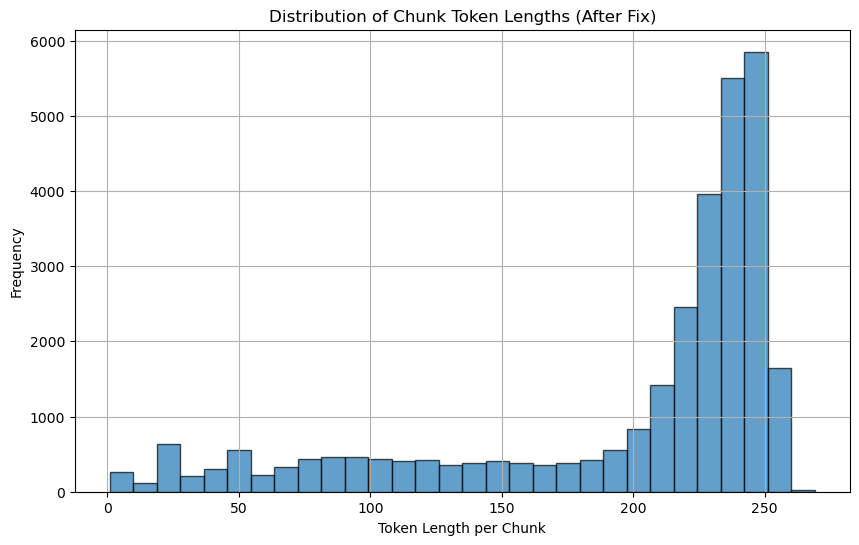

In [101]:
import matplotlib.pyplot as plt

# 청크 길이 데이터 수집
chunk_lengths = []
for example in chunked_dataset["train"]:
    for chunk in example["output"]:  # "output" 컬럼이 청크 데이터일 가능성 높음
        tokenized = tokenizer(chunk, add_special_tokens=True)  # 특수토큰 포함
        chunk_lengths.append(len(tokenized["input_ids"]))

# 텍스트 출력 (기본 통계)
print("Chunk Length Statistics:")
print(f"Total Chunks: {len(chunk_lengths)}")
print(f"Mean Length: {sum(chunk_lengths) / len(chunk_lengths):.2f} tokens")
print(f"Max Length: {max(chunk_lengths)} tokens")
print(f"Min Length: {min(chunk_lengths)} tokens")

# 히스토그램 그래프
plt.figure(figsize=(10, 6))
plt.hist(chunk_lengths, bins=30, alpha=0.7, edgecolor="black")
plt.xlabel("Token Length per Chunk")
plt.ylabel("Frequency")
plt.title("Distribution of Chunk Token Lengths (After Fix)")
plt.grid(True)
plt.show()


In [103]:
print(f"평균적인 청크 길이: {sum(chunk_lengths) / len(chunk_lengths):.2f} tokens")

평균적인 청크 길이: 198.30 tokens


#### 청크 데이터가 질문(input)과 답변(output)의 형식이 올바른지 확인

In [104]:
# 데이터셋의 구조 확인 (샘플 5개 출력)
for i in range(5):
    print(f"\n샘플 {i+1}:")
    print(f"질문 (input): {chunked_dataset['train'][i]['input']}")
    print(f"답변 (output): {chunked_dataset['train'][i]['output']}")
    print("-" * 80)



샘플 1:
질문 (input): ['저는 지금까지 회사생활에서 많은 걸 경험하면서 느낀 것이 있어서, 고민을 해보았습니다. 저는 이제 회사에서 대리까지 찍고 있는데, 대리에게 가면서부터 선배들과의 인간관계에서 어려움을 느꼈습니다. 제가 선배에게 전하는 의견이나 어떤 것에 대해서는 모두 무시하시는 것 같고, 불필요한 피드백을 주시면서 괜히 불편한 기분도 들고, 희생정신만 강조하시는 것 같습니다. 힘든 상황에서 기존의 선배나 동료에게 조언을 구해보면, 그들도 비슷한 상황에서 갇혀있는 것 같아서 도움이 되지 않습니다. 하지만 이런 어려움 때문에 집에서도 일이 떠오르고, 자고 일어나면 회사생활에 대한 걱정으로 기분도 좋지 않습니다. 이런 문제를 해결할 수 있는 방법을 알고 싶습니다.']
답변 (output): ['사우님은 대리로 진급하면서 선배들과의 인간관계에서 어려움을 느끼고 계시네요. 선배들이 사우님의 의견을 무시하며, 희생정신만 강조한다는 것에서 사우님은 상처를 받고 있다는 것 같습니다. 더구나 기존의 선배나 동료들에게 조언을 구하면, 그들도 비슷한 상황에서 갇혀있는 것 같아서 도움을 받기 어렵다는 것입니다. 사우님이 이런 문제로 인해 집에서도 일이 떠오르고, 자고 일어나면 회사생활에 대한 걱정으로 기분도 좋지 않다고 합니다. 이런 문제로 인해 사우님이 어떤 고민을 하고 계신 건지 함께 알아보도록 합시다. 사우님이 선배들과의 대인관계에서 어려움을 느끼신 것은 충분히 이해가 되고, 이를 악화시키는 다양한 요인이 있을 수 있습니다.', '이런 경우 더이상 상처를 받지 않으려면, 사우님이 어떤 것을 바라고 있는지, 선배들은 사우님을 어떻게 보는지, 그리고 사우님이 실제로 지켜야 하는 것들은 무엇인지 등을 다각도로 파악해야 합니다. 각각의 요인들이 어떤 관계로 구성되어 있는지 파악하고, 이를 토대로 실제로 이 문제를 해결할 수 있는 해결책을 찾아보면 좋을 것 같습니다. 우선, 사우님이 어떤 것을 원하는지, 선배들은 사우님을 어떻게 바라보는지, 그리고 사우님이 실제로 

#### 청크로 분할한 데이터 저장

In [111]:
import pandas as pd

# 데이터 변환
data_list = []
for example in chunked_dataset["train"]:
    input_text = " ".join(example["input"]) if isinstance(example["input"], list) else str(example["input"])  
    for chunk in example["output"]:  
        data_list.append({"input": input_text, "output": chunk})

# 데이터프레임 생성 후 CSV 저장
df = pd.DataFrame(data_list)
csv_path = "../../data/chunked_dataset.csv"
df.to_csv(csv_path, index=False, encoding="utf-8")

print(f"CSV 파일 저장 완료: {csv_path}")


CSV 파일 저장 완료: ../../data/chunked_dataset.csv


#### 데이터 길이 확인

In [112]:
import os
import pandas as pd

# 데이터 디렉토리 설정
data_dir = "../../data/"
file_name = "chunked_dataset.csv"
file_path = os.path.join(data_dir, file_name)

# 파일 존재 여부 확인
if not os.path.exists(file_path):
    print(f"파일이 존재하지 않습니다: {file_path}")
else:
    print("파일 발견:", file_path)

    # 데이터 로드
    df = pd.read_csv(file_path)

    # 데이터 기본 정보 출력
    print("\nDataset Info:")
    print(df.info())

    # 데이터 샘플 출력 (앞 5개 행)
    print("\nSample Data:")
    print(df.head())

    # 결측치 확인
    missing_values = df.isnull().sum()
    print("\nMissing Values per Column:")
    print(missing_values)

    # 올바른 컬럼명 확인
    expected_columns = ["input", "output"]
    if not all(col in df.columns for col in expected_columns):
        print("\n데이터 컬럼이 예상과 다릅니다. 현재 컬럼:", df.columns)
    else:
        # 텍스트 길이 계산
        df["input_length"] = df["input"].apply(lambda x: len(str(x)))
        df["output_length"] = df["output"].apply(lambda x: len(str(x)))

        # 길이 분포 출력
        print("\nText Length Statistics:")
        print(df[["input_length", "output_length"]].describe())

        # 짧거나 긴 샘플 확인
        print("\nShortest Input Samples:")
        print(df[df["input_length"] < 50].head())

        print("\nShortest Output Samples:")
        print(df[df["output_length"] < 50].head())

        print("\nLongest Input Samples:")
        print(df[df["input_length"] > 1000].head())

        print("\nLongest Output Samples:")
        print(df[df["output_length"] > 1000].head())


파일 발견: ../../data/chunked_dataset.csv

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30206 entries, 0 to 30205
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   input   30206 non-null  object
 1   output  30206 non-null  object
dtypes: object(2)
memory usage: 472.1+ KB
None

Sample Data:
                                               input  \
0  저는 지금까지 회사생활에서 많은 걸 경험하면서 느낀 것이 있어서, 고민을 해보았습니...   
1  저는 지금까지 회사생활에서 많은 걸 경험하면서 느낀 것이 있어서, 고민을 해보았습니...   
2  저는 지금까지 회사생활에서 많은 걸 경험하면서 느낀 것이 있어서, 고민을 해보았습니...   
3  최근에 학교에서 일이 많아져서 무척 바쁩니다. 시간이 없어서 잠을 충분히 못 자고,...   
4  최근에 학교에서 일이 많아져서 무척 바쁩니다. 시간이 없어서 잠을 충분히 못 자고,...   

                                              output  
0  사우님은 대리로 진급하면서 선배들과의 인간관계에서 어려움을 느끼고 계시네요. 선배들...  
1  이런 경우 더이상 상처를 받지 않으려면, 사우님이 어떤 것을 바라고 있는지, 선배들...  
2  이를 위해서는 사우님이 실제로 무엇을 할 수 있는지, 무엇을 할 수 없는지, 그리고...  
3  사우님 최근 학교 일과 직장 일로 인해 정말 바쁘게 지내고 있으시네요. 시간이 부족...  
4  이런 상황이 계속되면 스트레스가 증

In [113]:
# 입력과 출력 길이 통계 확인
print("\nInput Text Length Statistics:")
print(df["input_length"].describe())

print("\nOutput Text Length Statistics:")
print(df["output_length"].describe())


Input Text Length Statistics:
count    30206.00000
mean       192.28395
std         72.85264
min         18.00000
25%        145.00000
50%        187.00000
75%        233.00000
max       1203.00000
Name: input_length, dtype: float64

Output Text Length Statistics:
count    30206.000000
mean       325.379858
std        107.107626
min          2.000000
25%        297.000000
50%        367.000000
75%        396.000000
max        482.000000
Name: output_length, dtype: float64


## 토크나이징

#### 토크나이저 불러오기

In [ ]:
from transformers import AutoTokenizer

# 모델에 맞는 토크나이저 불러오기
MODEL_NAME = "Qwen/Qwen2-7B-Instruct"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, trust_remote_code=True)

# 토크나이저 패딩 토큰 설정
tokenizer.pad_token = tokenizer.eos_token


In [115]:
# 샘플 문장 토큰화 확인
sample_text = "청소년 고민이 있어요. 어떻게 해야 할까요?"
tokenized_sample = tokenizer(sample_text, return_tensors="pt")

# 결과 확인
print("토큰화된 샘플:")
print(tokenized_sample)
print("토큰 개수:", len(tokenized_sample["input_ids"][0]))


토큰화된 샘플:
{'input_ids': tensor([[143413, 126429, 125496,  12802, 127353,  35711,     13, 130108,  60716,
          89659,  95002, 138965,     30]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}
토큰 개수: 13


### 프롬프트 포함 데이터 생성

In [150]:
from datasets import Dataset

# CSV 파일 불러오기
file_path = "../../data/chunked_dataset.csv"
df = pd.read_csv(file_path)

# Dataset으로 변환 (Hugging Face `Dataset` 형식)
dataset = Dataset.from_pandas(df)

In [151]:
import re

def format_prompt(example):
    user_input = example["input"].strip()  # 질문 부분
    response = example["output"].strip()  # 상담사 응답 부분

    # 사용자 입력 부분을 명확하게 "사용자:"로 변경
    prompt = (
        f"사용자: {user_input}\n"
        f"AI 친구: {response}"
    )

    return {"text": prompt}

# 데이터셋에 적용
dataset = dataset.map(format_prompt)

# 샘플 확인
for i in range(3):
    print(f"\nSample {i+1}:")
    print(dataset[i]["text"])


Map:   0%|          | 0/30206 [00:00<?, ? examples/s]


Sample 1:
사용자: 저는 지금까지 회사생활에서 많은 걸 경험하면서 느낀 것이 있어서, 고민을 해보았습니다. 저는 이제 회사에서 대리까지 찍고 있는데, 대리에게 가면서부터 선배들과의 인간관계에서 어려움을 느꼈습니다. 제가 선배에게 전하는 의견이나 어떤 것에 대해서는 모두 무시하시는 것 같고, 불필요한 피드백을 주시면서 괜히 불편한 기분도 들고, 희생정신만 강조하시는 것 같습니다. 힘든 상황에서 기존의 선배나 동료에게 조언을 구해보면, 그들도 비슷한 상황에서 갇혀있는 것 같아서 도움이 되지 않습니다. 하지만 이런 어려움 때문에 집에서도 일이 떠오르고, 자고 일어나면 회사생활에 대한 걱정으로 기분도 좋지 않습니다. 이런 문제를 해결할 수 있는 방법을 알고 싶습니다.
AI 친구: 사우님은 대리로 진급하면서 선배들과의 인간관계에서 어려움을 느끼고 계시네요. 선배들이 사우님의 의견을 무시하며, 희생정신만 강조한다는 것에서 사우님은 상처를 받고 있다는 것 같습니다. 더구나 기존의 선배나 동료들에게 조언을 구하면, 그들도 비슷한 상황에서 갇혀있는 것 같아서 도움을 받기 어렵다는 것입니다. 사우님이 이런 문제로 인해 집에서도 일이 떠오르고, 자고 일어나면 회사생활에 대한 걱정으로 기분도 좋지 않다고 합니다. 이런 문제로 인해 사우님이 어떤 고민을 하고 계신 건지 함께 알아보도록 합시다. 사우님이 선배들과의 대인관계에서 어려움을 느끼신 것은 충분히 이해가 되고, 이를 악화시키는 다양한 요인이 있을 수 있습니다.

Sample 2:
사용자: 저는 지금까지 회사생활에서 많은 걸 경험하면서 느낀 것이 있어서, 고민을 해보았습니다. 저는 이제 회사에서 대리까지 찍고 있는데, 대리에게 가면서부터 선배들과의 인간관계에서 어려움을 느꼈습니다. 제가 선배에게 전하는 의견이나 어떤 것에 대해서는 모두 무시하시는 것 같고, 불필요한 피드백을 주시면서 괜히 불편한 기분도 들고, 희생정신만 강조하시는 것 같습니다. 힘든 상황에서 기존의 선배나 동료에게 조언을 구해보면, 그들도 비슷한 상황에

### 토크나이징 적용

In [152]:
# 토크나이징 함수 정의
def tokenize_function(example):
    return tokenizer(
        example["text"],  # 프롬프트 포함 텍스트
        padding="max_length",  # max_length에 맞춰 패딩 적용
        truncation=True,       # 길이가 초과되면 잘라냄
        max_length=512         # 적절한 max_length 설정 (필요시 조정 가능)
    )

# 데이터셋에 토크나이징 적용
tokenized_dataset = dataset.map(tokenize_function, batched=True)

# 샘플 확인
print("토큰화된 샘플:", tokenized_dataset[0])

Map:   0%|          | 0/30206 [00:00<?, ? examples/s]

토큰화된 샘플: {'input': '저는 지금까지 회사생활에서 많은 걸 경험하면서 느낀 것이 있어서, 고민을 해보았습니다. 저는 이제 회사에서 대리까지 찍고 있는데, 대리에게 가면서부터 선배들과의 인간관계에서 어려움을 느꼈습니다. 제가 선배에게 전하는 의견이나 어떤 것에 대해서는 모두 무시하시는 것 같고, 불필요한 피드백을 주시면서 괜히 불편한 기분도 들고, 희생정신만 강조하시는 것 같습니다. 힘든 상황에서 기존의 선배나 동료에게 조언을 구해보면, 그들도 비슷한 상황에서 갇혀있는 것 같아서 도움이 되지 않습니다. 하지만 이런 어려움 때문에 집에서도 일이 떠오르고, 자고 일어나면 회사생활에 대한 걱정으로 기분도 좋지 않습니다. 이런 문제를 해결할 수 있는 방법을 알고 싶습니다.', 'output': '사우님은 대리로 진급하면서 선배들과의 인간관계에서 어려움을 느끼고 계시네요. 선배들이 사우님의 의견을 무시하며, 희생정신만 강조한다는 것에서 사우님은 상처를 받고 있다는 것 같습니다. 더구나 기존의 선배나 동료들에게 조언을 구하면, 그들도 비슷한 상황에서 갇혀있는 것 같아서 도움을 받기 어렵다는 것입니다. 사우님이 이런 문제로 인해 집에서도 일이 떠오르고, 자고 일어나면 회사생활에 대한 걱정으로 기분도 좋지 않다고 합니다. 이런 문제로 인해 사우님이 어떤 고민을 하고 계신 건지 함께 알아보도록 합시다. 사우님이 선배들과의 대인관계에서 어려움을 느끼신 것은 충분히 이해가 되고, 이를 악화시키는 다양한 요인이 있을 수 있습니다.', 'text': '사용자: 저는 지금까지 회사생활에서 많은 걸 경험하면서 느낀 것이 있어서, 고민을 해보았습니다. 저는 이제 회사에서 대리까지 찍고 있는데, 대리에게 가면서부터 선배들과의 인간관계에서 어려움을 느꼈습니다. 제가 선배에게 전하는 의견이나 어떤 것에 대해서는 모두 무시하시는 것 같고, 불필요한 피드백을 주시면서 괜히 불편한 기분도 들고, 희생정신만 강조하시는 것 같습니다. 힘든 상황에서 기존의 선배나 동료에게 조언을 구해보면, 그

## 데이터셋을 PyTorch 형식으로 변환

In [153]:
# 전체 데이터셋에서 80%는 train, 나머지 20%는 test로 분리
train_size = int(0.8 * len(tokenized_dataset))
train_data = tokenized_dataset.select(range(train_size))  # 80% 훈련 데이터
test_data = tokenized_dataset.select(range(train_size, len(tokenized_dataset)))  # 20% 테스트 데이터

# PyTorch Dataset 생성
train_dataset = ChatbotDataset(train_data)
test_dataset = ChatbotDataset(test_data)

print("Train Dataset Size:", len(train_dataset))
print("Test Dataset Size:", len(test_dataset))


Train Dataset Size: 24164
Test Dataset Size: 6042


In [156]:
from torch.utils.data import Dataset
import torch

# PyTorch Dataset 정의
class ChatbotDataset(Dataset):
    def __init__(self, tokenized_data):
        self.input_ids = torch.tensor(tokenized_data["input_ids"], dtype=torch.long)
        self.attention_mask = torch.tensor(tokenized_data["attention_mask"], dtype=torch.long)

        # 'labels'이 없을 경우 input_ids 복사
        self.labels = self.input_ids.clone()

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return {
            "input_ids": self.input_ids[idx],
            "attention_mask": self.attention_mask[idx],
            "labels": self.labels[idx],  
        }

# 이미 분할된 데이터 (train_data, test_data)
train_dataset = ChatbotDataset(train_data)  # 이미 나누어진 train_data 사용
test_dataset = ChatbotDataset(test_data)    # 이미 나누어진 test_data 사용

# 확인
print("Train Dataset Size:", len(train_dataset))
print("Test Dataset Size:", len(test_dataset))


Train Dataset Size: 24164
Test Dataset Size: 6042


In [160]:
# 데이터를 저장하기
dataset.save_to_disk("../../data/processed_dataset")


Saving the dataset (0/1 shards):   0%|          | 0/30206 [00:00<?, ? examples/s]

## DataLoader 생성

In [158]:
from torch.utils.data import DataLoader

# 배치 크기 설정 (CPU 실행이므로 작게 설정)
batch_size = 8

# DataLoader 생성
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# DataLoader에서 첫 번째 배치 확인
batch = next(iter(train_dataloader))

print("첫 번째 배치 input_ids 크기:", batch["input_ids"].shape)
print("첫 번째 배치 attention_mask 크기:", batch["attention_mask"].shape)


첫 번째 배치 input_ids 크기: torch.Size([8, 512])
첫 번째 배치 attention_mask 크기: torch.Size([8, 512])


In [161]:
# 저장한 데이터셋 불러오기
from datasets import load_from_disk
dataset = load_from_disk("../../data/processed_dataset")


## QLoRA 적용 + 4-bit 양자화 적용

In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
from peft import LoraConfig, get_peft_model
import torch

# 모델 이름 지정 
model_name = "Qwen/Qwen2-7B-Instruct" 

# 4-bit 양자화 설정
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,  # 4-bit 양자화 활성화
    bnb_4bit_compute_dtype=torch.float16,  # 연산에 사용할 데이터 타입
    bnb_4bit_use_double_quant=True,  # 더블 양자화 사용
    bnb_4bit_quant_type="nf4",  # NF4 양자화 적용
)

# 모델 및 토크나이저 불러오기 (4-bit 양자화 적용)
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=bnb_config,  # 4-bit 양자화 설정 적용
    device_map="auto",  # 자동으로 GPU 할당
)

# QLoRA 설정
lora_config = LoraConfig(
    r=8,  # Low-rank factor (LoRA 랭크)
    lora_alpha=16,  # Scaling factor
    target_modules=["q_proj", "v_proj"],  # LoRA 적용할 모듈
    lora_dropout=0.1,  # 드롭아웃 비율
    bias="none",  # Bias 업데이트 비활성화
)

# LoRA 적용
model = get_peft_model(model, lora_config)

# 모델 GPU로 이동
model = model.to("cuda")

# 모델 구조 확인
print(model)


### 하이퍼파라미터 설정 (TrainingArguments)

In [ ]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="../../data/models/results",  # 모델 저장 경로
    evaluation_strategy="epoch",  # 매 epoch마다 평가 수행
    save_strategy="epoch",  # 체크포인트 저장 전략
    learning_rate=2e-5,  # 학습률
    per_device_train_batch_size=8,  # GPU 메모리에 맞게 조정
    per_device_eval_batch_size=8,  # 평가 시 배치 크기
    num_train_epochs=3,  # 학습 반복 횟수
    weight_decay=0.01,  # 가중치 감소 (L2 정규화)
    logging_dir="../../data/models/logs",  # 로그 저장 경로
    logging_steps=500,  # 로그 출력 주기
    save_steps=500,  # 모델 저장 주기
    save_total_limit=2,  # 저장할 체크포인트 개수 제한
    fp16=True,  # 16-bit 연산 활성화
    push_to_hub=False,  # 모델 허깅페이스 업로드 여부
    gradient_accumulation_steps=2,  # 그래디언트 누적 (메모리 절약)
    load_best_model_at_end=True,  # 가장 성능 좋은 모델 로드
)


In [ ]:
from transformers import Trainer

# Trainer 설정
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,  # 토크나이저 포함
)

# 학습 시작
trainer.train()


## 모델 저장

In [ ]:
# 모델 저장
trainer.save_model("../../data/models/finetuned_model")
tokenizer.save_pretrained("../../data/models/finetuned_model")


## Perplexity 평가

In [ ]:
import torch
import math
from transformers import AutoModelForCausalLM

def compute_perplexity(model, dataloader, tokenizer, device):
    model.eval()  # 평가 모드
    total_loss = 0
    total_tokens = 0

    with torch.no_grad():
        for batch in dataloader:
            inputs = {key: val.to(device) for key, val in batch.items()}
            outputs = model(**inputs, labels=inputs["input_ids"])
            loss = outputs.loss

            total_loss += loss.item() * inputs["input_ids"].size(1)
            total_tokens += inputs["input_ids"].size(1)

    ppl = math.exp(total_loss / total_tokens)
    return ppl

# 평가 실행
perplexity = compute_perplexity(model, test_dataloader, tokenizer, device)
print(f"Perplexity (PPL): {perplexity:.2f}")


## ROUGE 평가

In [ ]:
from datasets import load_metric

# ROUGE 평가 함수
def compute_rouge(model, dataloader, tokenizer, device):
    rouge_metric = load_metric("rouge")
    model.eval()

    all_references = []
    all_hypotheses = []

    with torch.no_grad():
        for batch in dataloader:
            inputs = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)

            outputs = model.generate(input_ids=inputs, attention_mask=attention_mask, max_length=128)
            decoded_preds = tokenizer.batch_decode(outputs, skip_special_tokens=True)
            decoded_labels = tokenizer.batch_decode(inputs, skip_special_tokens=True)

            all_hypotheses.extend(decoded_preds)
            all_references.extend(decoded_labels)

    # ROUGE 계산
    rouge_scores = rouge_metric.compute(predictions=all_hypotheses, references=all_references)
    return rouge_scores

# 평가 실행
rouge_scores = compute_rouge(model, test_dataloader, tokenizer, device)
print("ROUGE Scores:", rouge_scores)


## BLEU 평가

In [ ]:
from datasets import load_metric

# BLEU 평가 함수
def compute_bleu(model, dataloader, tokenizer, device):
    bleu_metric = load_metric("bleu")
    model.eval()

    all_references = []
    all_hypotheses = []

    with torch.no_grad():
        for batch in dataloader:
            inputs = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)

            outputs = model.generate(input_ids=inputs, attention_mask=attention_mask, max_length=128)
            decoded_preds = tokenizer.batch_decode(outputs, skip_special_tokens=True)
            decoded_labels = tokenizer.batch_decode(inputs, skip_special_tokens=True)

            all_hypotheses.extend([pred.split() for pred in decoded_preds])
            all_references.extend([[label.split()] for label in decoded_labels])

    # BLEU 계산
    bleu_score = bleu_metric.compute(predictions=all_hypotheses, references=all_references)
    return bleu_score

# 평가 실행
bleu_score = compute_bleu(model, test_dataloader, tokenizer, device)
print("BLEU Score:", bleu_score)


## 최종 평가 결과 비교

In [ ]:
print("=== 최종 평가 결과 ===")
print(f"Perplexity (PPL): {perplexity}")
print(f"ROUGE Score: {rouge_scores}")
print(f"BLEU Score: {bleu_score}")

## 테스트

In [ ]:
import torch

# GPU 사용 여부 확인
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def generate_answer(prompt):
    model.eval()  # 모델을 평가 모드로 설정
    inputs = tokenizer(prompt, return_tensors="pt").to(device)  # 입력을 GPU 또는 CPU로 전달
    with torch.no_grad():  # 그래디언트 계산 방지
        output = model.generate(**inputs, max_length=100)
    return tokenizer.decode(output[0], skip_special_tokens=True)

# 테스트 문장
test_prompts = [
    "아 진짜 요즘 너무 스트레스 받아... 어떻게 하면 좀 괜찮아질까?",
    "나 요즘 친구랑 사이가 좀 안 좋은데... 어떻게 해야 할까?",
    "학교에서 너무 힘들어... 선생님이 맨날 나만 혼내는 것 같아.",
    "부모님이 내 말을 잘 안 들어줘서 너무 답답해 ㅠㅠ",
    "시험 때문에 너무 불안한데, 어떡하지?"
]

for prompt in test_prompts:
    response = generate_answer(prompt)
    print(f"\n👤 사용자: {prompt}")
    print(f"🤖 챗봇: {response}")
